Este script genera graficos de frecuencia instantanea de la DOE vs. tiempo durante el estimulo. Superpone cada estimulacion y las separa en sub-plots por hora consecutiva de estimulacion. Tiene la opcion de separar entre el trial de la mañana y la tarde.

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [113]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.stats import zscore

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = r'D:\Datos G. omarorum\Fish6\Objeto\Trial 1 y 2\raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_vid = sorted(glob.glob('*.h5'))
on_off1 = pd.read_csv(os.path.join(data_folder, 'on_off_trial1.csv'), header=None) #asegurarse de terner los .csv en la misma carpeta que el pkl
on_off2 = pd.read_csv(os.path.join(data_folder, 'on_off_trial2.csv'), header=None)
files_EOD = sorted(glob.glob('*.bin'))
obj_coordinates = [291, 213]
#definimos parametros
sf = 10000


In [114]:
#cargamos el archivo de FB-DOE
with open('fish6_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

A continuacion tenemos algunas celdas que pre-procesan nuestros datos y filtran los archivos para solo utilizar los que contienen registros durante la estimulacion.

In [115]:
# generamos la lista files_start que contiene las timestamps en formato datetime del comienzo de cada uno de los archivos
files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in FB_doe['FB-DOE'].keys()]
print(files_start)# convertimos on_off1 a formato datetime
on_off1[0] = on_off1[0].apply(lambda x: datetime.fromisoformat(x[:-6]))

# ahora pasamos on_off1 a formato dataframe y nos quedamos solo con la columna de tiempo de on 
on_off = pd.DataFrame(np.zeros(shape=(len(on_off1), 2)), columns=['Trial 1', 'Trial 2'])
on_off['Trial 1'] = on_off1.drop(on_off1.columns[[1, 2]], axis=1)

# hacemos lo mismo con on_off2 y lo agregamos al dataframe on_off
on_off2[0] = on_off2[0].apply(lambda x: datetime.fromisoformat(x[:-6]))
on_off['Trial 2'] = on_off2.drop(on_off2.columns[[1, 2]], axis=1)

[datetime.datetime(2024, 2, 2, 17, 1, 11), datetime.datetime(2024, 2, 2, 17, 21, 12), datetime.datetime(2024, 2, 2, 17, 41, 12), datetime.datetime(2024, 2, 2, 18, 1, 12), datetime.datetime(2024, 2, 2, 18, 21, 12), datetime.datetime(2024, 2, 2, 18, 41, 12), datetime.datetime(2024, 2, 2, 19, 1, 12), datetime.datetime(2024, 2, 2, 19, 21, 12), datetime.datetime(2024, 2, 2, 19, 41, 13), datetime.datetime(2024, 2, 2, 20, 1, 13), datetime.datetime(2024, 2, 2, 20, 21, 13), datetime.datetime(2024, 2, 2, 20, 41, 13), datetime.datetime(2024, 2, 2, 21, 1, 13), datetime.datetime(2024, 2, 2, 21, 21, 13), datetime.datetime(2024, 2, 2, 21, 41, 13), datetime.datetime(2024, 2, 2, 22, 1, 14), datetime.datetime(2024, 2, 2, 22, 21, 14), datetime.datetime(2024, 2, 2, 22, 41, 14), datetime.datetime(2024, 2, 2, 23, 1, 14), datetime.datetime(2024, 2, 2, 23, 21, 14), datetime.datetime(2024, 2, 2, 23, 41, 14), datetime.datetime(2024, 2, 3, 0, 1, 15), datetime.datetime(2024, 2, 3, 0, 21, 15), datetime.datetime(20

In [116]:
# guardamos algunos tiempos de referencia para filtrar los archivos 
trial1_last = on_off['Trial 1'].iloc[-1]
trial2_last = on_off['Trial 2'].iloc[-1]
trial2_first = on_off['Trial 2'].iloc[0]

# generamos n_trial1 y n_trial2 que contiene los indices de los archivos que nos interesan para cada trial
n_trial1 = [i for i, start in enumerate(files_start) if (start - trial1_last).total_seconds() < 0]
n_trial2 = [i for i, start in enumerate(files_start) if (start - trial2_last).total_seconds() < 0 and (start - trial2_first).total_seconds() > 0]

# Achatamos on_off y lo ordenamos
on_off = pd.DataFrame(on_off.values.flatten(), columns=['On_off']).sort_values(by='On_off')
on_off.reset_index(inplace=True)

In [117]:
files_start = [files_start[x] for x in n_trial1 + n_trial2] #nos quedamos solo con los timestamps de los archivos de interes

FB_DOE = FB_doe['FB-DOE'] #guardamos las frequencias en una variable
Peak_time = FB_doe['Peak-time'] # guardamos los peak-times en otra variable

keys1 = [list(FB_DOE.keys())[i] for i in n_trial1] #guardamos las keys del trial 1
keys2 = [list(FB_DOE.keys())[i] for i in n_trial2] #guardamos las keys del trial 2

FB_DOE_T1 = {key: FB_DOE.get(key) for key in keys1} # guardamos las frecuencias del trial 1 
Peaks_T1 = {key: Peak_time.get(key) for key in keys1}  #guardamos los peak-times del trial 1
FB_DOE_T2 = {key: FB_DOE.get(key) for key in keys2}  #guardamos las frecuencias del trial 2
Peaks_T2 = {key: Peak_time.get(key) for key in keys2} #guardamos los peak-times del trial 2

n_files = len(FB_DOE_T1) + len(FB_DOE_T2) #guardamos el numero de files con el que estamos trabajando para usar despues

In [118]:
files_start[1]

datetime.datetime(2024, 2, 2, 17, 21, 12)

In [119]:
#organizamos cada on segun su archivo de registro
files = pd.DataFrame(np.zeros(shape=(4, n_files)), columns=list(FB_DOE_T1.keys()) + list(FB_DOE_T2.keys()))  # Usamos Int64Dtype para que pueda haber nans en columnas de int

for i, column in enumerate(files.columns[:-1], start=0):
    start = files_start[i]
    end = files_start[i+1]
    s = 0
    for j in range(len(on_off)):
        condition = (start - on_off['On_off'][j]).total_seconds() < 0 and (end - on_off['On_off'][j]).total_seconds() > 0
        if condition:
            files.loc[s, column] = j
            s += 1

files = files.dropna(how='all')
files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
files.iloc[0, 0] = 0 # el primer objeto tiene que ser un 0
files = files.dropna(how='all')

files

,2024-02-02T17_01_11.,2024-02-02T17_21_12.,2024-02-02T17_41_12.,2024-02-02T18_01_12.,2024-02-02T18_21_12.,2024-02-02T18_41_12.,2024-02-02T19_01_12.,2024-02-02T19_21_12.,2024-02-02T19_41_13.,2024-02-02T20_01_13.,...,2024-02-03T06_01_17.,2024-02-03T06_21_17.,2024-02-03T06_41_18.,2024-02-03T07_01_18.,2024-02-03T07_21_18.,2024-02-03T07_41_18.,2024-02-03T08_01_18.,2024-02-03T08_21_18.,2024-02-03T08_41_18.,2024-02-03T09_01_19.
0,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,...,75.0,80.0,85.0,90.0,95.0,100.0,105.0,109.0,114.0,NaN
1,1.0,6.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,...,76.0,81.0,86.0,91.0,96.0,101.0,106.0,110.0,115.0,NaN
2,2.0,7.0,12.0,17.0,22.0,27.0,32.0,37.0,42.0,47.0,...,77.0,82.0,87.0,92.0,97.0,102.0,107.0,111.0,116.0,NaN
3,3.0,8.0,13.0,18.0,23.0,28.0,33.0,38.0,43.0,48.0,...,78.0,83.0,88.0,93.0,98.0,103.0,108.0,112.0,117.0,NaN
4,4.0,9.0,14.0,19.0,24.0,29.0,34.0,39.0,44.0,NaN,...,79.0,84.0,89.0,94.0,99.0,104.0,NaN,113.0,118.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
#inicializamos las listas
EOD_peaks_on = {'Trial 1': [], 'Trial 2': []}
time_EOD_all  = {'Trial 1': [], 'Trial 2': []}
time_obj_all = {'Trial 1': [], 'Trial 2': []}
EOD_f_on = {'Trial 1': [], 'Trial 2': []}
distancia = {'Trial 1': [], 'Trial 2': [], 'Trial 2T' : [], 'Trial 1T': []}

In [121]:
for k in range(len(files.keys())-1): #loopeamos entre los archivos de interes
    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[k],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+len(EOD)/sf, num=len(EOD))
    del EOD
    #vid = pd.read_hdf(files_vid[k])
    #mouth = vid.iloc[:, 0:2]
    #Calculate chin to object distance for each frame
    #fishdistance = np.array([distance.euclidean(obj_coordinates,[mouth.iloc[i, 0], mouth.iloc[i, 1]]) for i in range(len(mouth))])
    #durationVideo = len(vid)/50 
    #videoTime = np.linspace(start=start, stop=start+durationVideo, num=round(durationVideo*50))
 
    time_obj = np.zeros((6)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)
    
    if k < len(n_trial1):
        key = 'Trial 1'
        EOD_peaks = np.array(Peaks_T1[list(Peaks_T1.keys())[k]])
        EOD_freq = np.array(FB_DOE_T1[list(FB_DOE_T1.keys())[k]])
    
    else:
        key = 'Trial 2'
        EOD_peaks = np.array(Peaks_T2[list(Peaks_T2.keys())[k-len(n_trial1)]])
        EOD_freq = np.array(FB_DOE_T2[list(FB_DOE_T2.keys())[k-len(n_trial1)]])
        
    l=0
    for i in files.iloc[:,k]:
        if not np.isnan(i):
                s = abs(midnight - on_off['On_off'][int(i)]).total_seconds() #calculamos el inicio del on
                time_obj[l] = s
                time_obj_all[key].append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all[key].append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l+=1
    
    time_peaks = time_EOD[EOD_peaks]
    EOD_zscore = zscore(EOD_freq)
    for j in range(time_obj.shape[0]):
        if not time_obj[j]==0:
            range_on = [time_obj[j]-5, time_obj[j]+10] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
            #con = [range_on[0] <= t and t <= range_on[1] for t in videoTime]
            condition = [range_on[0] <= time and time <= range_on[1] for time in time_peaks]

            EOD_peaks_on[key].append(EOD_peaks[condition])
            EOD_f_on[key].append(EOD_zscore[condition[:-1]])


    print('termino archivo ' + str(k))

termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11
termino archivo 12
termino archivo 13
termino archivo 14
termino archivo 15
termino archivo 16
termino archivo 17
termino archivo 18
termino archivo 19
termino archivo 20
termino archivo 21
termino archivo 22
termino archivo 23


In [124]:
print(len(EOD_peaks_on['Trial 1']), len(EOD_peaks_on['Trial 2']))

58 54


Como en algunos archivos hay menos de 5 ons, debemos eliminar las listas vacias generadas en nuestros diccionarios

In [123]:
for key in ['Trial 1', 'Trial 2']:
    EOD_peaks_on[key] = [sublist for sublist in EOD_peaks_on[key] if len(sublist) > 0]
    EOD_f_on[key] = [sublist for sublist in EOD_f_on[key] if len(sublist) > 0]

Las siguientes celdas calculan las medianas por trial y en total a traves del tiempo. Como cada serie temporal es FB-DOE vs tiempo, estas no estan alineadas. Para resolver eso y calcular la FB-DOE media vs tiempo generamos ventanas temporales de 100 ms a las cuales redondear. 

Las siguientes celdas contienen el codigo para generar las graficas. La primera genera la paleta de colores, la segunda genera el plot para todos los trials juntos y la tercera para los trials 1 y 2 separados

In [125]:
import matplotlib.cm as cm
colormap = cm.get_cmap('cool')
colors1 = [colormap(i+100) for i in range(len(time_obj_all['Trial 1']))]
colormap = cm.get_cmap('cool')
colors2 = [colormap(i+100) for i in range(len(time_obj_all['Trial 2']))]
colors = {'Trial 1': colors1, 'Trial 2':  colors2}


C:\Users\Compras\AppData\Local\Temp\ipykernel_13292\537094389.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('cool')
C:\Users\Compras\AppData\Local\Temp\ipykernel_13292\537094389.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('cool')


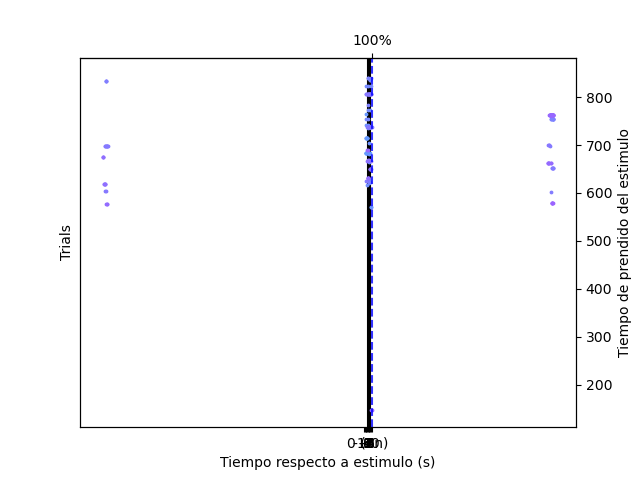

In [126]:
%matplotlib widget 
#plot all trials
n_per_on = []
t_novelty = []
trials = []
n_peaks = []
day_switch = len(EOD_peaks_on['Trial 1'])
fig, ax = plt.subplots()
ax2 = ax.twinx()
k=0
for key in EOD_peaks_on.keys():
    time = time_EOD_all[key]
    obj = time_obj_all[key]
    EOD_zscore = EOD_f_on[key]
    peaks = EOD_peaks_on[key]

    
    if len(EOD_zscore)>0 :
        for z_score, peak, t, o, c in zip(EOD_zscore, peaks, time,  obj, colors[key]):
            peak = peak[:len(z_score)]
            #plt.scatter(t[peak]-o, np.ones(len(peak))*k, color='k', s=.5, alpha=.5)
            if len(z_score)>0:
                events =[]
                for k in np.arange(1,len(z_score)-3):
                    is_event = z_score[k] > 2 and z_score[k+1] > 2 and z_score[k+2] > 2 and z_score[k-1] < 2
                    if is_event: 
                        events.append(k) 
                i_novel = peak[[k for k in events]]
                novel = z_score[events]
                n_per_on.append(len(i_novel)/len(peak))
                n_peaks.append(len(peak))
                t_novelty.append(o)
                trials.append(k)
                plt.scatter(t[i_novel]-o, np.ones(len(i_novel))*k, color=c, s=3)
            k += .01
        #ax.plot(np.linspace(-.5, 10, len(medians_all_trials['all'])), medians_all_trials['all'], color='k')
        #ax.plot(np.linspace(-.5, 10, len(medians_all_trials[key])), medians_all_trials[key], color='k', linestyle='--')

        #ax.set_ylim([-.5, 2])
        ax.set_ylabel('Trials')
        ax.set_xlabel('Tiempo respecto a estimulo (s)')


bar_width = .01
for i, y in zip(trials,n_per_on):
    bar_position = 10 -(y) +2
    ax2.barh(i + bar_width*i, y, height=bar_width, color='k', alpha=.5, left=bar_position)  # Bar for each line

hours = [int(trial // 3600) for trial in t_novelty]
minutes = [int(trial % 3600) // 60 for trial in t_novelty]
dates = [datetime.now().replace(hour=hour, minute=minute, second=0, microsecond=0) for hour, minute in zip(hours, minutes)]

#ax2.fill_between(x = range(-10,11),y2=0, y1=trials[day_switch], alpha=.1)
ax.set_yticks([])

ax.set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
ax.set_xticklabels([-10,-8,-6,-4,-2,'0 (on)',2,4,6,8,10])
ax.axvline(x=0, color='k', linestyle='-', label='Vertical Line')
ax.axvline(x=5, color='k', linestyle='-', label='Vertical Line')
ax2.axvline(x=11, color='b', linestyle='--',alpha=.8, label='Vertical Line')

x_hist = ax.secondary_xaxis('top')
x_hist.set_xticks([11])
x_hist.set_xticklabels(['100%'])
#ax2.set_yticks(np.linspace(0,k,len(trials)))
#ax2.set_yticklabels([date.strftime("%H:%M") for date in dates], fontsize=8)

ax2.set_ylabel('Tiempo de prendido del estimulo')
plt.show()


In [129]:
count = 0
for i in n_per_on[58:]:
    if i>0:
        count+=1 
(count/len(n_per_on[58:]))*100

48.148148148148145

In [40]:
len(n_per_on)

114

In [33]:
p = []
p.append(sum([x*y for x,y in zip(n_per_on, n_peaks)])/1200)


In [19]:
p

[9.405]